In [1]:
nevecs = 60
ncomps = 1500
nbasecomps = 20
crop_size=180
ncauses = 3
dr_method = 'KPCA'

In [2]:
import os, sys
from pathlib import Path

macaw_path = Path(os.getcwd()).parent.parent.parent
sys.path.append(str(macaw_path) +'/')

train_path = macaw_path/'data'/'ukbb'/'axial'/f'train_hc_data_{dr_method}_{ncomps}.pkl'
model_base_path = macaw_path/'models'/f'{dr_method}_{ncomps}'/f'{nevecs}'

if not os.path.exists(model_base_path):
    os.makedirs(model_base_path)

In [3]:
import pickle

with open(train_path, 'rb') as f:
    train = pickle.load(f)
    
sex = train['sex']
age = train['age']
bmi = train['bmi']
# imgs = train['imgs']
min_age = train['min_age']

encoded_data = train['encoded_data']
kpca = train['kpca']

In [4]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    age+=min_age
    
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    imgs = kpca.inverse_transform(latent_enc)
    return age,bmi,imgs

[Text(0.5, 1.0, 'PCA0')]

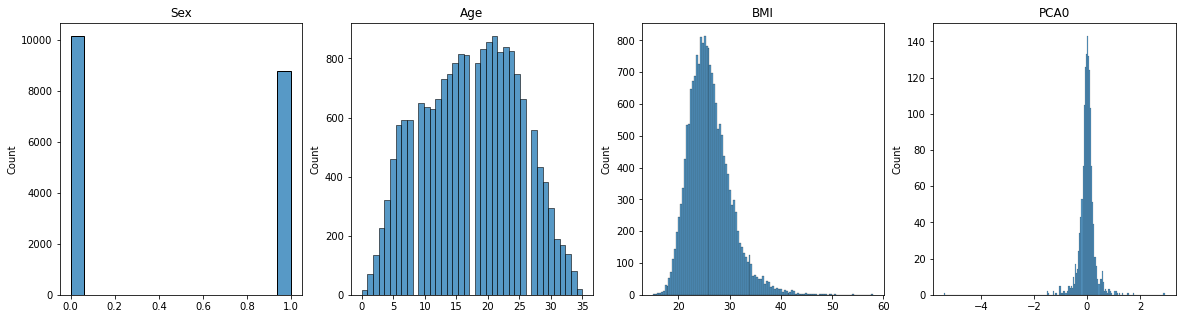

In [5]:
import seaborn as sns

sb = 4
fig, axs = plt.subplots(1,sb, figsize=(sb*5,5))

sns.histplot(sex,ax=axs[0],fill=True)
axs[0].set(title = "Sex")
sns.histplot(age,ax=axs[1], fill=True)
axs[1].set(title="Age")
sns.histplot(bmi,ax=axs[2], fill=True)
axs[2].set(title="BMI")
sns.histplot(encoded_data[0],ax=axs[3], fill=True)
axs[3].set(title="PCA0")

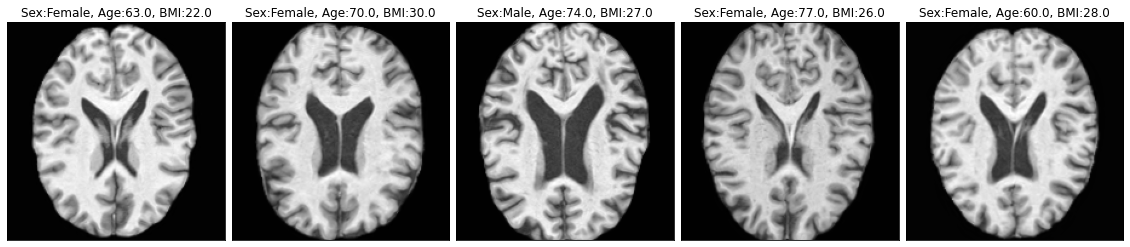

In [6]:
import utils.visualize as vis

plt.rcParams['figure.figsize'] = (20,4)
nsamples = 5

idx = np.random.randint(0,age.shape[0],nsamples)
re = recons(age[idx],bmi[idx],encoded_data[idx])

sex_t = ['Male' if round(s) else 'Female' for s in sex[idx]]
titles_sam = [f'Sex:{s}, Age:{a}, BMI:{np.round(b)}' for s,a,b in zip(sex_t, re[0],re[1])]
fig  = vis.img_grid([i.reshape(crop_size,crop_size).T for i in re[2]],cols=nsamples,titles=titles_sam)

## Causal Graph

In [7]:
sex_to_latents = [(0,i) for i in range(ncauses,nevecs+ncauses)]
sex_to_bmi = [(0,2)]

age_to_latents = [(1,i) for i in range(ncauses,nevecs+ncauses)]
age_to_bmi = [(1,2)]

bmi_to_latents = [(2,i) for i in range(ncauses,nevecs+ncauses)]
autoregressive_latents = [(i,j) for i in range(ncauses,nevecs+ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = [(i,j) for i in range(ncauses,2*ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = []
edges = sex_to_latents + sex_to_bmi+ age_to_latents + age_to_bmi+bmi_to_latents + autoregressive_latents

## Priors

In [8]:
P_sex = np.sum(sex)/len(sex)
print(P_sex)

unique_values, counts = np.unique(age, return_counts=True)
P_age = counts/np.sum(counts)
P_age

0.46398986967762357


array([0.00079143, 0.00364058, 0.00707012, 0.01192423, 0.01698939,
       0.02416504, 0.03033821, 0.0311824 , 0.0311824 , 0.03429536,
       0.03345117, 0.03324012, 0.03503403, 0.03856909, 0.03936052,
       0.04147101, 0.04294835, 0.0427373 , 0.04147101, 0.04395083,
       0.04505883, 0.0462196 , 0.0434232 , 0.04421464, 0.04347597,
       0.03941329, 0.03498127, 0.02949401, 0.02279323, 0.02015512,
       0.01551206, 0.00997204, 0.00896956, 0.00733393, 0.00416821,
       0.00100248])

<BarContainer object of 36 artists>

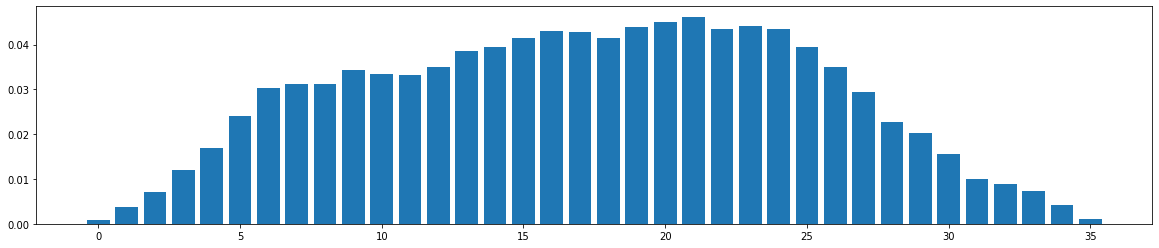

In [9]:
plt.bar(np.arange(36),P_age)

In [10]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
import torch.distributions as td
import torch

priors = [(slice(0,1),td.Bernoulli(torch.tensor([P_sex]).to(config.device))), # sex
          (slice(1,2),td.Categorical(torch.tensor([P_age]).to(config.device))), # age
          (slice(2,3),td.Normal(torch.zeros(1).to(config.device), torch.ones(1).to(config.device))), #BMI
          (slice(3,nbasecomps+3),td.Normal(torch.zeros(nbasecomps).to(config.device), torch.ones(nbasecomps).to(config.device))), # base_comps
          (slice(nbasecomps+3,nevecs+3),td.Normal(torch.zeros(nevecs-nbasecomps).to(config.device), torch.ones(nevecs-nbasecomps).to(config.device))), # new_comps
         ]

<ipython-input-11-7922a6f003d5>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/torch/csrc/utils/tensor_new.cpp:201.)
  (slice(1,2),td.Categorical(torch.tensor([P_age]).to(config.device))), # age


In [12]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [13]:
from macaw import MACAW

loss_vals = []
for e in range(0,ncomps-nbasecomps,nevecs-nbasecomps):
    save_path = model_base_path/f'{e}.pt'    
    ed =  encoded_data[:,e:e+nevecs]
    print(e,e+nevecs)
    
    if not os.path.exists(save_path): 
       
        X = np.hstack([sex[:,np.newaxis], age[:,np.newaxis], bmi[:,np.newaxis], ed])    

        macaw = MACAW.MACAW(config)
        loss_vals.append(macaw.fit_with_priors(X,edges, priors))

        torch.save(macaw,save_path)
    else:
        print("Skipping")

0 60
Skipping
40 100
Skipping
80 140
Skipping
120 180
Skipping
160 220
Skipping
200 260
Skipping
240 300
Skipping
280 340
Skipping
320 380
Skipping
360 420
Skipping
400 460
Skipping
440 500
Skipping
480 540
Skipping
520 580
Skipping
560 620
Skipping
600 660
Skipping
640 700
Skipping
680 740
Skipping
720 780
Skipping
760 820
Skipping
800 860
Skipping
840 900
Skipping
880 940
Skipping
920 980
Skipping
960 1020
Skipping
1000 1060
Skipping
1040 1100
Skipping
1080 1140
Skipping
1120 1180
Skipping
1160 1220
Skipping
1200 1260
Skipping
1240 1300
Skipping
1280 1340
Skipping
1320 1380
Skipping
1360 1420
Skipping
1400 1460
Skipping
1440 1500
Skipping


In [14]:
plt.plot(np.array(loss_vals[0][0]))
plt.plot(np.array(loss_vals[0][1]))

IndexError: list index out of range

In [15]:
model_path = model_base_path/'hyperparameters.pkl'

with open(model_path, 'wb') as f:
    pickle.dump({'ncomps':ncomps, 'nevecs':nevecs,'nbasecomps':nbasecomps, 'ncauses':ncauses, 'crop_size':crop_size, 'age_bins':len(P_age)}, f)

## Linear regression

In [16]:
ed =  encoded_data[:,:nevecs]
X = np.hstack([sex[:,np.newaxis], bmi[:,np.newaxis], ed])    

In [17]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, age)

In [18]:
reg.score(X, age)

0.3828817384627552

In [19]:
lr_path = model_base_path/'lr.pkl'

with open(lr_path, 'wb') as f:
    pickle.dump({'reg':reg}, f)

In [20]:
lr_path

PosixPath('/data/Code/macaw/models/KPCA_1500/60/lr.pkl')

In [21]:
reg.coef_

array([-1.93380084, -0.08408014,  0.82265255, -0.14003464,  0.39997611,
        0.29563904, -0.6291832 ,  0.29101853, -0.81844672,  0.16452014,
        0.20794163,  0.25167876, -0.23729705,  0.16279364,  0.27799602,
       -0.14778999,  0.03430245, -0.4588327 , -0.15312628,  0.17727738,
       -0.076739  ,  0.04886179, -0.05189614, -0.05152546,  0.77421185,
        0.63192161,  0.64954357, -0.71290704, -0.15194997,  0.02061489,
       -0.28731939,  0.70502952, -0.45584889,  0.1464741 ,  0.21829608,
        0.26848682,  0.05579185, -0.25328788,  0.13971419, -0.09847999,
        0.25349868, -0.31135831, -0.49308058, -0.46921868, -0.03421149,
        0.22239821,  0.10026002,  0.46702826, -0.31773711, -0.29730684,
       -0.13214943,  0.01803825, -0.19990418,  0.18731606, -0.00677422,
        0.39811988, -0.13835447, -0.26767954, -0.79978494,  0.03896002,
       -0.01729093, -0.25515299])

In [22]:
np.mean(np.abs(reg.predict(X) - age))

4.836404867585474

In [23]:
idx = 0
macaw = torch.load(model_base_path/f'{idx}.pt')
X_test = np.hstack([sex[:,np.newaxis], age[:,np.newaxis], bmi[:,np.newaxis], encoded_data[:,idx:nevecs+idx]])

In [24]:
encoded_data.shape

(18953, 1500)

In [25]:
probs=[]
for i in range(36):
    X_test[:,1] = i
    probs.append(macaw.log_likelihood(X_test))

In [26]:
pexp = np.exp(np.array(probs))
pexp_sum = np.sum(pexp,axis=0)
p = pexp/pexp_sum

<ipython-input-26-649b6bdced27>:3: RuntimeWarning: invalid value encountered in true_divide
  p = pexp/pexp_sum


In [27]:
pred_labels = np.argmax(probs, axis=0)

In [28]:
age_bins=36

<Axes: ylabel='Count'>

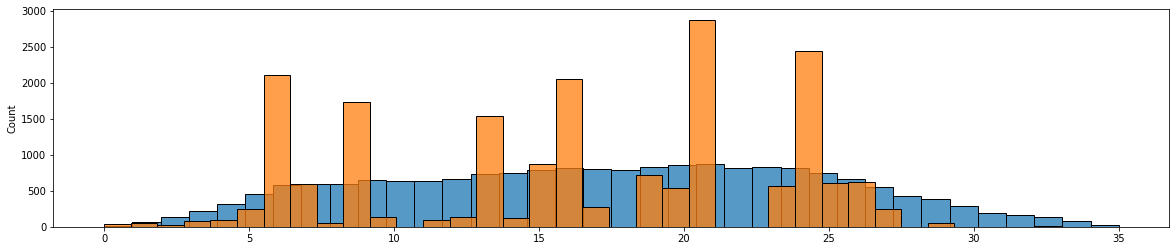

In [29]:
sns.histplot(age, bins=age_bins)
sns.histplot(pred_labels,bins=age_bins)

<BarContainer object of 36 artists>

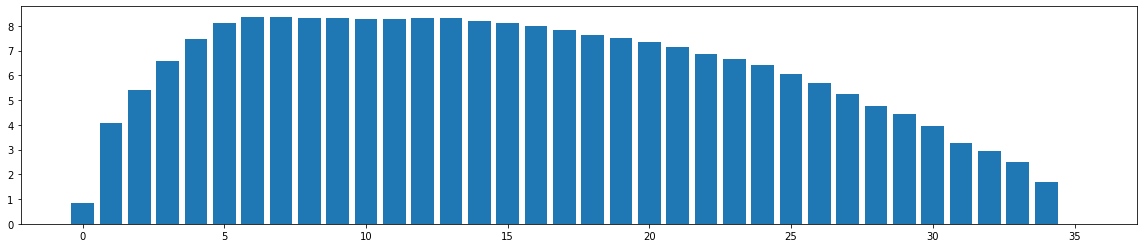

In [30]:
l = np.array(probs)[:,80]
plt.bar(np.arange(36),l-np.min(l))

<Axes: ylabel='Count'>

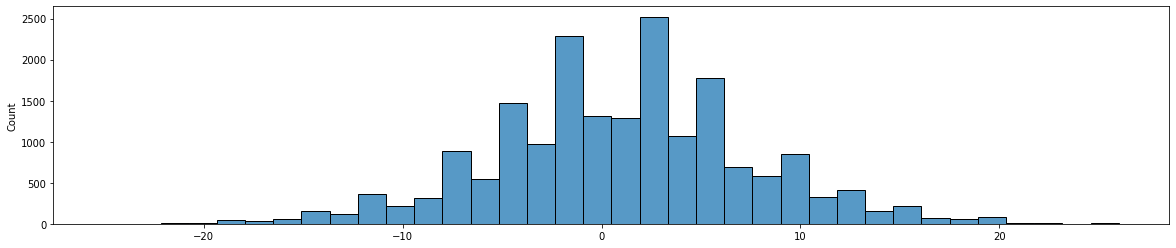

In [31]:
sns.histplot(age-pred_labels, bins=age_bins)

In [32]:
np.mean(np.abs(pred_labels - age))

5.088112699836437